In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load dataset
df = pd.read_csv("crude-oil-price.csv")

# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"])

# Sort by date (critical for time series)
df = df.sort_values("date")




In [3]:
from fredapi import Fred

fred = Fred(api_key="YOUR_API_KEY_IS_HERE")

cpi = fred.get_series("CPIAUCSL")
interest_rate = fred.get_series("FEDFUNDS")


ValueError: Bad Request.  The value for variable api_key is not a 32 character alpha-numeric lower-case string.  Read https://fred.stlouisfed.org/docs/api/api_key.html for more information.

In [ ]:
macro_df = pd.DataFrame({
    "date": cpi.index,
    "inflation": cpi.values,
    "interest_rate": interest_rate.reindex(cpi.index).values
})

macro_df = macro_df.resample("M", on="date").mean()
macro_df.reset_index(inplace=True)


C:\Users\Lenovo X1 Yoga\AppData\Local\Temp\ipykernel_7020\2883836284.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  macro_df = macro_df.resample("M", on="date").mean()


In [ ]:
df["year_month"] = df["date"].dt.to_period("M")
macro_df["year_month"] = macro_df["date"].dt.to_period("M")


C:\Users\Lenovo X1 Yoga\AppData\Local\Temp\ipykernel_7020\588449333.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["date"].dt.to_period("M")


In [ ]:
df = df.merge(
    macro_df[["year_month", "inflation", "interest_rate"]],
    on="year_month",
    how="inner"
)


In [ ]:
df["date"] = df["year_month"].dt.to_timestamp()
df.drop(columns="year_month", inplace=True)


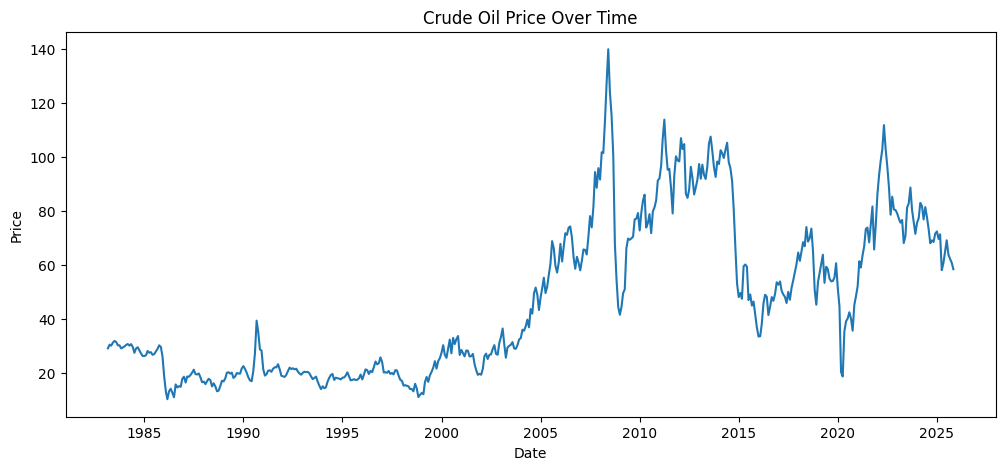

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["price"])
plt.title("Crude Oil Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [ ]:
df = df.dropna().reset_index(drop=True)

df["percentChange"] = df["percentChange"].clip(-50, 50)
df["change"] = df["change"].clip(-50, 50)


In [ ]:
features = ["price", "percentChange", "change", "inflation", "interest_rate"]
data = df[features].values


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


In [ ]:
price_scaler = MinMaxScaler()
price_scaler.fit(df[["price"]])

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [ ]:
window_size= 24

In [ ]:
X, y = [], []

WINDOW_SIZE = 24

for i in range(WINDOW_SIZE, len(data_scaled)):
    X.append(data_scaled[i-WINDOW_SIZE:i])
    y.append(data_scaled[i, 0])  # predict price only



In [ ]:
X = np.array(X)
y = np.array(y)


In [ ]:
X.shape

(487, 24, 5)

In [ ]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [ ]:

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])



c:\Users\Lenovo X1 Yoga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.0479 - val_loss: 0.0087
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0172 - val_loss: 0.0214
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0161 - val_loss: 0.0076
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0093 - val_loss: 0.0076
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0115 - val_loss: 0.0078
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0087 - val_loss: 0.0073
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0100 - val_loss: 0.0077
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0076 - val_loss: 0.0084
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0060 - val_loss: 0.0064
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.

In [ ]:
predictions = model.predict(X_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


In [ ]:


# Inverse transform
predictions_real = price_scaler.inverse_transform(predictions)
y_test_real = price_scaler.inverse_transform(y_test.reshape(-1, 1))




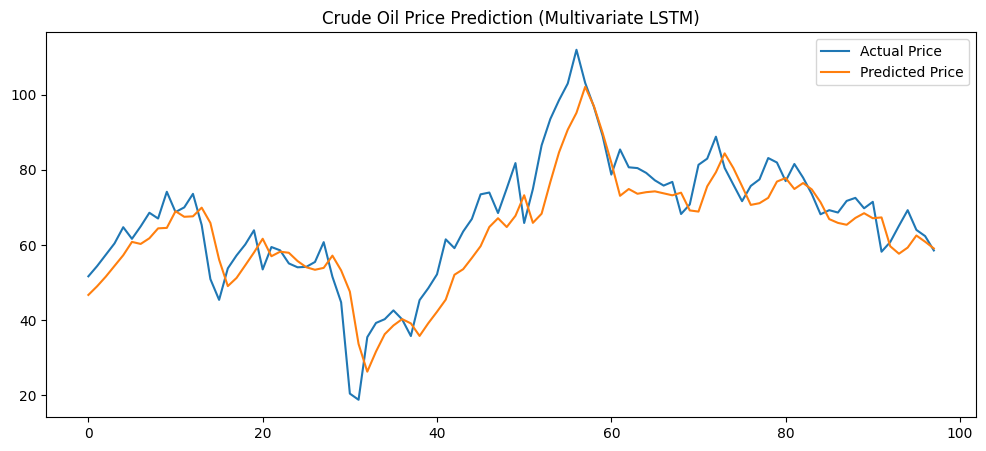

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test_real, label="Actual Price")
plt.plot(predictions_real, label="Predicted Price")
plt.legend()
plt.title("Crude Oil Price Prediction (Multivariate LSTM)")
plt.show()


In [ ]:
## Future Price Forecast (Next 12 Months)


In [ ]:
last_window = data_scaled[-WINDOW_SIZE:]
last_window = last_window.reshape(1, WINDOW_SIZE, X.shape[2])


In [ ]:
future_predictions = []

for _ in range(12):
    next_price = model.predict(last_window)[0][0]
    future_predictions.append(next_price)

    next_step = last_window[:, -1, :].copy()
    next_step[0] = next_price

    last_window = np.append(
    last_window[:, 1:, :],
    next_step.reshape(1, 1, -1),
    axis=1
)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [ ]:
future_predictions = scaler.inverse_transform(
    np.column_stack([
        future_predictions,
        np.zeros((12, X.shape[2] - 1))
    ])
)[:, 0]


C:\Users\Lenovo X1 Yoga\AppData\Local\Temp\ipykernel_7020\2921315455.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(


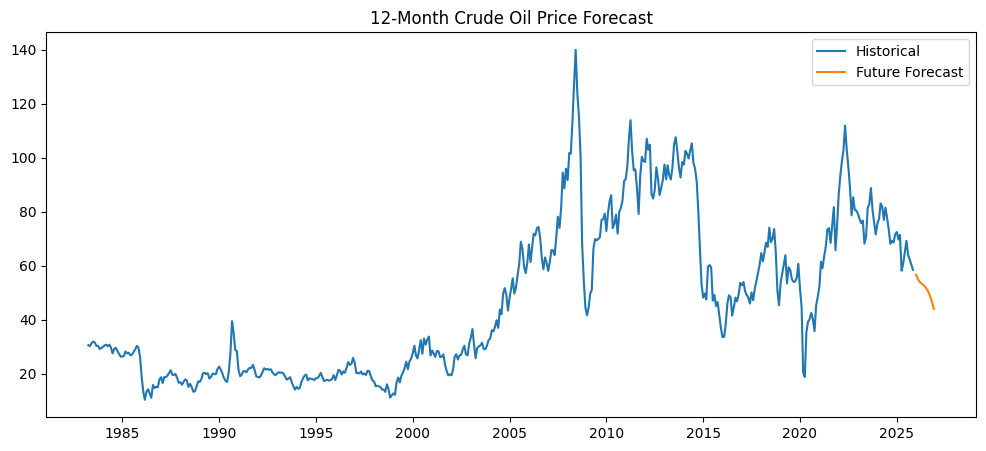

In [ ]:
future_dates = pd.date_range(
    start=df["date"].iloc[-1],
    periods=13,
    freq="M"
)[1:]

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["price"], label="Historical")
plt.plot(future_dates, future_predictions, label="Future Forecast")
plt.legend()
plt.title("12-Month Crude Oil Price Forecast")
plt.show()


In [ ]:
model.save("crude_oil_prediction_lstm.keras")



In [ ]:
plt.savefig("prediction_real_macro.png", dpi=300, bbox_inches="tight")
plt.show()


<Figure size 640x480 with 0 Axes>

In [ ]:
plt.savefig("future_forecast_real_macro.png", dpi=300, bbox_inches="tight")
plt.show()


<Figure size 640x480 with 0 Axes>